In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

%matplotlib inline

In [2]:
np.seterr("raise")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

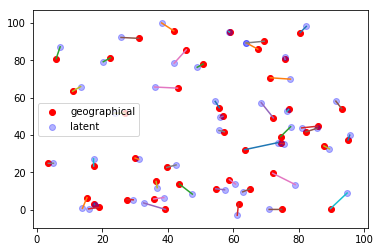

In [3]:
N = 47
X = np.random.uniform(low=0, high=100, size=(N,2))
Z = X + np.random.normal(scale=1/np.sqrt(0.1), size=(N,2))

plt.scatter(X[:,0], X[:,1], c="r", alpha=1, label="geographical")
plt.scatter(Z[:,0], Z[:,1], c="b", alpha=0.3, label="latent")
plt.plot((X[:,0], Z[:,0]), (X[:,1], Z[:,1]))
plt.legend()

In [4]:
d = np.random.uniform(low=-1, high=1, size=(N,N))
d += d.T
d *= 1
d += np.array([[np.linalg.norm(Z[i] - Z[j]) for i in range(N)] for j in range(N)])

In [5]:
class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        
        self.m = 0
        self.v = 0
        self.t = 0
        
    def __call__(self, w, grad):
        self.t += 1
        self.m = self.β1*self.m + (1-self.β1)*grad
        self.v = self.β2*self.v + (1-self.β2)*np.square(grad)
        m_ = self.m / (1-self.β1**self.t)
        v_ = self.v / (1-self.β2**self.t)
        return w - self.α * m_ / (np.sqrt(v_) + self.ϵ)

In [6]:
class BGMDS:
    """
    Bayesian Geographical MultiDimensional Scaling (BGMDS)
    """
    def __init__(self, λ, τ):
        """
        params:
        λ : precision parameter of latent coordinate
        τ : precision parameter of unsimilarity
        """
        self.λ = λ
        self.τ = τ
        
    def fit(self, X, d, lr=0.01, maxiter=1000, optimizer="adam"):
        """
        X : geographical coordinates
        d : unsimilarity
        lr : learning rate
        maxiter : iteration count
        optimizer : "adam" or gradient decent
        """
        self.N, self.M = X.shape
        self.X = X
        self.d = d
        self.maxiter = int(maxiter)
        
        # initalization
        self.μ = np.random.normal(loc=self.X, scale=1/np.sqrt(self.λ))
        self.σ = np.random.uniform(low=0.9, high=1.1, size=(self.N, self.M)) * self.λ
        self.ρ = self._softplus_inv(self.σ)
        
        self.loss = np.empty(self.maxiter)
        self.penalty = np.empty(self.maxiter)
        if optimizer == "adam":
            optimizer1 = AdamOptimizer(lr)
            optimizer2 = AdamOptimizer(lr)
        with tqdm(total = maxiter) as pbar:
            for i in range(self.maxiter):
                # re-parameterization
                ϵ_ = np.random.normal(size=(self.N, self.M))
                z_ = self.μ + self.σ*ϵ_
                δ_ = self._distance(z_)

                self.loss[i], self.penalty[i] = self._calc_loss(z_, ϵ_, δ_)
                pbar.update(1)
                pbar.set_postfix(loss=self.loss[i])

                # gradient
                Δμ = self._gradμ(z_, ϵ_, δ_)
                Δρ = self._gradρ(z_, ϵ_, δ_)
                
                if optimizer == "adam":
                    # update (adam)
                    self.μ = optimizer1(self.μ, Δμ)
                    self.ρ = optimizer1(self.ρ, Δρ)
                else:
                    # update (gradient decent)
                    self.μ -= lr * Δμ
                    self.ρ -= lr * Δρ
                self.σ = self._softplus(self.ρ)
            else:
                self.δ = self._distance(self.μ)
        
    def _softplus(self, x, limits=30, under=1e-10):
        y = x.copy()
        y[x<limits] = np.log(1+np.exp(x[x<limits]))
        y[y<under] = under
        return y
    
    def _softplus_inv(self, x):
        return np.log(np.exp(x)-1)
    
    def _softplus_grad(self, x):
        return 1 / (1+np.exp(-x))
    
    def _distance(self, X):
        return np.array([[np.linalg.norm(X[i] - X[j]) for i in range(self.N)] for j in range(self.N)])
    
    def _calc_loss(self, z_, ϵ_, δ_):
        loss = np.sum(-0.5*(ϵ_**2 + 2*np.log(self.σ) + np.log(2*np.pi)))
        for i in range(self.N):
            for j in range(i+1, self.N):
                loss -= -0.5*(self.τ*(self.d[i,j] - δ_[i,j])**2 - np.log(self.τ) + np.log(2*np.pi))
        penalty = np.sum(-0.5*(self.λ*(z_-self.X)**2 - np.log(self.λ) + np.log(2*np.pi)))
        loss -= penalty
        return loss, -penalty
    
    def _gradμ(self, z_, ϵ_, δ_):
        grad = np.zeros((self.N, self.M))
        for n in range(self.N):
            mask = np.ones(self.N, dtype=bool)
            mask[n] = False
            grad[n] -= np.sum(-(z_ - z_[n])[mask] / δ_[mask, n, np.newaxis] * self.τ * (self.d - δ_)[mask, n, np.newaxis], axis=0)
        grad -= -self.λ * (z_ - self.X)
        return grad
    
    def _gradρ(self, z_, ϵ_, δ_):
        grad = -1 / self.σ
        _grad = np.zeros((self.N, self.M))
        for n in range(self.N):
            mask = np.ones(self.N, dtype=bool)
            mask[n] = False
            _grad[n] += np.sum(-(z_ - z_[n])[mask] / δ_[mask, n, np.newaxis] * self.τ * (self.d - δ_)[mask, n, np.newaxis], axis=0)
        grad -= _grad*ϵ_
        grad -= -self.λ * (z_ - self.X) * ϵ_
        grad *= self._softplus_grad(self.ρ)
        return grad    

100%|██████████| 1000/1000 [00:23<00:00, 41.95it/s, loss=1.69e+03]


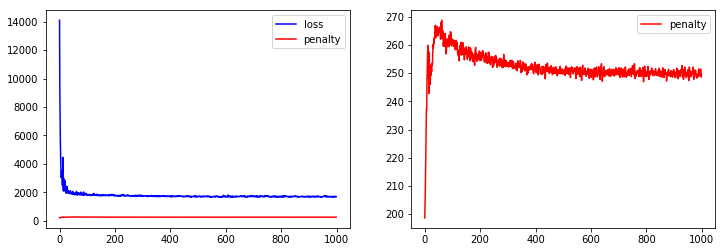

In [7]:
model = BGMDS(λ=0.1, τ=1)
model.fit(X, d, lr=1, maxiter=1000)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(model.loss, c="b", label="loss")
plt.plot(model.penalty, c="r", label="penalty")
plt.legend()
plt.subplot(122)
plt.plot(model.penalty, c="r", label="penalty")
plt.legend();

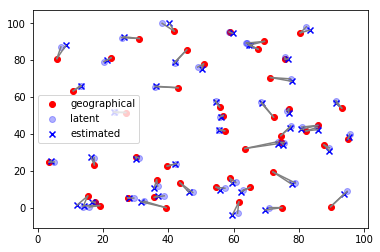

In [8]:
plt.scatter(X[:,0], X[:,1], c="r", alpha=1, label="geographical")
plt.scatter(Z[:,0], Z[:,1], c="b", alpha=0.3, label="latent")
plt.plot((X[:,0], Z[:,0]), (X[:,1], Z[:,1]), c="grey")
plt.scatter(model.μ[:,0], model.μ[:,1], c="b", marker="x", label="estimated")
plt.plot((X[:,0], model.μ[:,0]), (X[:,1], model.μ[:,1]), c="grey")
plt.legend()

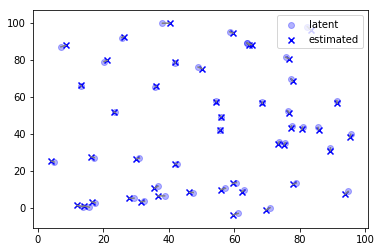

In [9]:
plt.scatter(Z[:,0], Z[:,1], c="b", alpha=0.3, label="latent")
plt.scatter(model.μ[:,0], model.μ[:,1], c="b", marker="x", label="estimated")
plt.plot((Z[:,0], model.μ[:,0]), (Z[:,1], model.μ[:,1]), c="grey")
plt.legend()

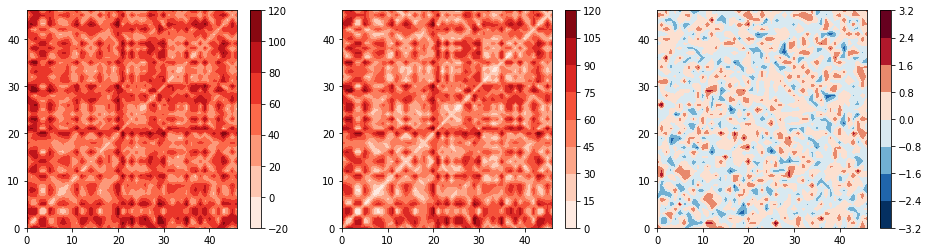

In [10]:
plt.figure(figsize=(16,4))
plt.subplot(131)
plt.contourf(model.d, vmax=max(model.d.max(), model.δ.max()), cmap="Reds")
plt.colorbar()
plt.subplot(132)
plt.contourf(model.δ, vmax=max(model.d.max(), model.δ.max()), cmap="Reds")
plt.colorbar()
plt.subplot(133)
plt.contourf(model.d - model.δ, cmap="RdBu_r", vmin=-np.abs(model.d - model.δ).max(), vmax=np.abs(model.d - model.δ).max())
plt.colorbar()

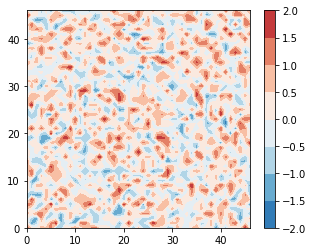

In [11]:
plt.figure(figsize=(5,4))
plt.contourf(model.d - model._distance(Z), cmap="RdBu_r", vmin=-np.abs(model.d - model.δ).max(), vmax=np.abs(model.d - model.δ).max())
plt.colorbar()